# Load MAD data

In [25]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from libemg.feature_extractor import FeatureExtractor
from libemg.utils import get_windows
import umap

sys.path.append('../')
from lift.datasets import get_mad_sample

In [3]:
# download dataset
import os
mad_base_dir = '../datasets/MyoArmbandDataset'
if not os.path.exists(mad_base_dir):
    os.system(f'git clone https://github.com/UlysseCoteAllard/MyoArmbandDataset {mad_base_dir}')

In [14]:
data_path = '../datasets/MyoArmbandDataset/PreTrainingDataset/Female0/training0/'
emg_list, label_list = get_mad_sample(data_path, filter_labels = True)
sort_id = np.argsort(label_list)
label_list = [label_list[i] for i in sort_id]
emg_list = [emg_list[i] for i in sort_id]
# I used labels 0 - 4 (including 4), where label 0 is rest

min_len = min([len(emg) for emg in emg_list])
short_emgs = [emg[:min_len,:] for emg in emg_list]
short_labels = [np.repeat(label, repeats=min_len) for label in label_list]

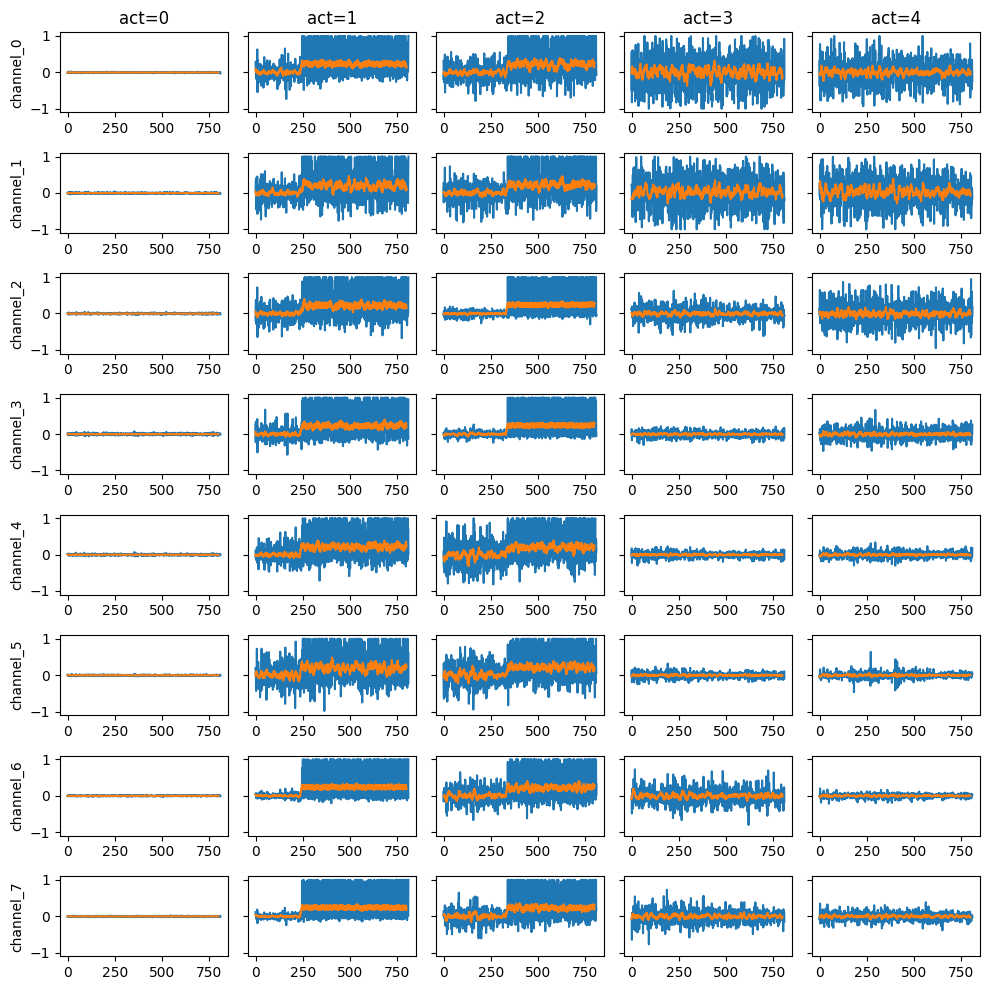

In [18]:
def moving_mean(signal, window_size=10):
    return np.array([np.mean(signal[i:i+window_size]) for i in range(len(signal) - window_size)])

# plot emg signals for each action
num_rows = short_emgs[0].shape[-1]
num_cols = len(short_labels)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10), sharey=True)
for i in range(num_rows):
    ax[i, 0].set_ylabel(f"channel_{i}")
    for j in range(num_cols):
        ax[0, j].set_title(f"act={j}")
        ax[i, j].plot(short_emgs[j][:, i])
        ax[i, j].plot(moving_mean(short_emgs[j][:, i]))
plt.tight_layout()
plt.show()

In [46]:
feature_list = ['MAV', 'SSC', 'ZC', 'WL']

def extract_features_labels(emg_list, label_list):
    """apply windows to every action"""
    fe = FeatureExtractor()

    features = [None] * len(emg_list)
    for i, emg in enumerate(emg_list):
        windows = get_windows(emg, 200, 50)

        features[i] = fe.extract_features(feature_list, windows)
        features[i] = np.stack(list(features[i].values()), axis=-1)

    short_labels = [np.repeat(label, repeats=len(f)) for label, f in zip(label_list, features)]

    features = np.concatenate(features, axis=0)
    short_labels = np.concatenate(short_labels, axis=0)

    # # log transform MAV and WL
    # features[:, :, 0] = np.log(features[:, :, 0])
    # features[:, :, 3] = np.log(features[:, :, 3])
    return features, short_labels

In [47]:
# aggregrate all female data
features = [None] * 9
labels = [None] * 9
for i in range(9):
    data_path = f'../datasets/MyoArmbandDataset/PreTrainingDataset/Female{i}/training0/'
    emg_list, label_list = get_mad_sample(data_path, filter_labels = True)
    features[i], labels[i] = extract_features_labels(emg_list, label_list)
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

print(features.shape, labels.shape)

(713, 8, 4) (713,)


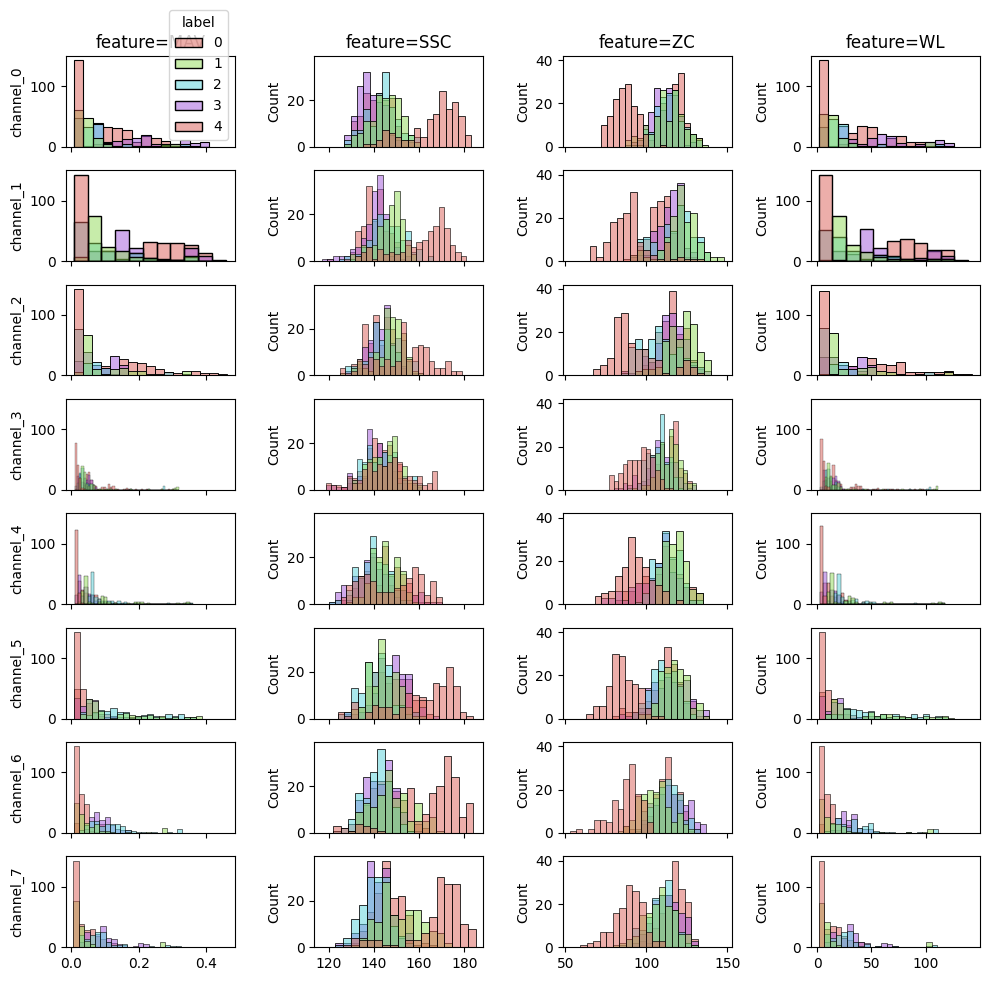

In [48]:
num_rows = features.shape[1]
num_cols = features.shape[2]
fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10), sharex="col", sharey="col")
for i in range(num_rows):
    ax[i, 0].set_ylabel(f"channel_{i}")
    for j in range(num_cols):
        ax[0, j].set_title(f"feature={feature_list[j]}")
        sns.histplot(
            data=pd.DataFrame({"feature": features[:, i, j], "label": labels}),
            x="feature",
            hue="label",
            bins="fd",
            palette="hls",
            legend=True if (i == 0) and (j == 0) else False,
            ax=ax[i, j],
        )
        ax[i, j].set_xlabel("")
plt.tight_layout()
plt.show()

In [61]:
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean",
    n_jobs=1,
    random_state=0,
)
embeddings = reducer.fit_transform(features.reshape(len(features), -1))

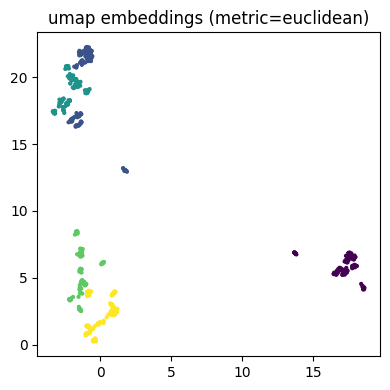

In [65]:
# plot embedding by actions
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, s=4)
ax.set_title("umap embeddings (metric=euclidean)")
plt.tight_layout()
plt.show()